# Image processing
## Project : Face mask detection using yolov5
By Guillaume PRÉBOT and Tyfenn ELOY

### Part 1: Setup of the environment
Since we will be using yolov5 we will need to pull it from its repository

In [ ]:
!rm -rf yolov5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -qr requirements.txt

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import xml.etree.ElementTree as ET 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [1]:
#Going to the root of our project folder
os.chdir('../')

NameError: name 'os' is not defined

In [2]:
#Variables containing path to the input and output direcotry 
input_data = 'dataset'
output_data = os.getcwd()

In [3]:
# Path to the anotation and images
annotations_path = input_data + "/annotations"
images_path = input_data + "/images"

### Part 2: Seting up the annotations
Getting all the data from the annotation files (in .xml) to put them in pandas dataframe

In [4]:
#This whole cell is used to exctact the data from the annotation file in XML 
dataset = {
            "file":[],
            "name":[],    
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
           }

for anno in glob.glob(annotations_path+"/*.xml"):
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            for attr in list(elem):
                
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['name']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file']+=[anno.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]

In [5]:
#Making the dictionnary a pandas Dataframe and displaying it
df=pd.DataFrame(dataset)
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax
0,maksssksksss299,without_mask,301,400,62,194,160,320
1,maksssksksss528,without_mask,301,400,43,169,149,308
2,maksssksksss272,mask_weared_incorrect,275,400,48,107,218,304
3,maksssksksss514,with_mask,400,267,28,78,43,99
4,maksssksksss514,with_mask,400,267,160,66,176,83


In [ ]:
#Creating the dict of classes
name_dict = {
    'with_mask': 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2 
}

df['class'] = df['name'].map(name_dict)

In [ ]:
np.sort(df.name.unique())

### Part 3 : Creating the test and training data
Splitting the data in training set and testing set

In [ ]:
#Getting the list of all the images
fileNames = [*os.listdir(images_path)]
print('There are {} images in the dataset'.format(len(fileNames)))

In [ ]:
#Splitting the data in training and testing
from sklearn.model_selection import train_test_split
train, test = train_test_split(fileNames, test_size=0.1, random_state=22)
test, val = train_test_split(test, test_size=0.7, random_state=22)
print("Length of Train =",len(train))
print("="*30)
print("Length of Valid =",len(val))
print("="*30)
print("Length of test =", len(test))

In [ ]:
# create separate train test and validation dir inside yolo/data/
os.chdir(output_data)
os.mkdir('./yolov5/data/train')
os.mkdir('./yolov5/data/val')
os.mkdir('./yolov5/data/test')
os.mkdir('./yolov5/data/train/images')
os.mkdir('./yolov5/data/train/labels')
os.mkdir('./yolov5/data/test/images')
os.mkdir('./yolov5/data/test/labels')
os.mkdir('./yolov5/data/val/images')
os.mkdir('./yolov5/data/val/labels')

### Part 4: Resizing the images and annotations
We will need to normalize all the images, and their annotations for yolo to work properly

In [ ]:
#Copy all images in the given folder and resize them all
from PIL import Image

def copyImages(imageList, folder_Name):
    for image in imageList:
        img = Image.open(input_data+"/images/"+image)
        img1 = img.resize((640, 480))
        _ = img1.save(output_data+"/yolov5/data/"+folder_Name+"/images/"+image)

copyImages(train, "train")
copyImages(val, "val")
copyImages(test, "test")

In [ ]:
df.head()

In [ ]:
# Change the bounding box coordinates to fit with the previous resizing
df['xmax'] = (640/df['width'])*df['xmax']
df['ymax'] = (480/df['height'])*df['ymax']
df['xmin'] = (640/df['width'])*df['xmin']
df['ymin'] = (480/df['height'])*df['ymin']

In [ ]:
#Casting to int
df[['xmax', 'ymax', 'xmin', 'ymin']] = df[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64')

In [ ]:
# Changing center, height and width to fit the previous resizing 
df['x_center'] = (df['xmax']+df['xmin'])/(2*640)
df['y_center'] = (df['ymax']+df['ymin'])/(2*480)
df['box_height'] = (df['xmax']-df['xmin'])/(640)
df['box_width'] = (df['ymax']-df['ymin'])/(480)

In [ ]:
df.head()

In [ ]:
df = df.astype('string')

In [ ]:
# Getting all the images from a given folder, and making a dataframe of all the labels associated
def create_labels(image_list, data_name):
    fileNames = [x.split(".")[0] for x in image_list]

    for name in fileNames:
        data = df[df.file==name]
        box_list = []
        
        for index in range(len(data)):
            row = data.iloc[index]
            box_list.append(row['class']+" "+row["x_center"]+" "+row["y_center"]\
                        +" "+row["box_height"]+" "+row["box_width"])
            
        text = "\n".join(box_list)
        with open(output_data+"/yolov5/data/"+data_name+"/labels/"+name+".txt", "w") as file:
            file.write(text)


create_labels(train, "train")
create_labels(val, "val")
create_labels(test, "test")

### Part 5: Running and displaying results
This part is about configuring the model and running the algorithm

In [7]:
# go to YOLO directory
%cd yolov5

/Users/gprebot/Desktop/Image_Analysis/Projet/yolov5


In [ ]:
# to display images
from IPython.display import Image, clear_output
import torch
from yolov5 import utils
display = utils.notebook_init()

In [ ]:
# configure .yaml file to guide the model for training
yaml_text = """train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']"""

with open("data/data.yaml", 'w') as file:
    file.write(yaml_text)

%cat data/data.yaml

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [1]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
    - [10,13, 16,30, 33,23]  # P3/8
    - [30,61, 62,45, 59,119]  # P4/16
    - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
    [[-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
    [-1, 3, BottleneckCSP, [512, False]],  # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
    [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],  # cat head P4
    [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],  # cat head P5
    [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
    ]

UsageError: Cell magic `%%writetemplate` not found.


In [ ]:
# train yolov5s on custom data for 100 epochs
# measure its performance
# we are going to use a pre-trained weights from yolov5.pt model

start = datetime.now()
!python3 train.py --img 640 --batch 32 --epochs 50 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_results  --cache
end = datetime.now()

In [ ]:
print("Runtime =",end-start)

In [ ]:
#Visualizing training results 
img = plt.imread('runs/train/yolov5s_results/train_batch0.jpg')
plt.figure(figsize=(20,15))
plt.imshow(img)
plt.axis('off')
plt.show()

In [8]:
!python3 detect.py --source data/test/images/ --weight runs/train/yolov5s_results/weights/best.pt --name expTestImage --conf 0.4

detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=data/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=expTestImage, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-177-gd059d1d torch 1.11.0 CPU

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7251912 parameters, 0 gradients, 16.8 GFLOPs
image 1/25 /Users/gprebot/Desktop/Image_Analysis/Projet/yolov5/data/test/images/maksssksksss121.png: 480x640 7 without_masks, Done. (0.422s)
image 2/25 /Users/gprebot/Desktop/Image_Analysis/Projet/yolov5/data/test/images/maksssksksss167.png: 480x640 4 with_masks, Done. (0.339s)
image 3/25 /Users/gprebot/Desktop/Image_Analysis/Projet/yolov5/data/test/images/maksssksksss174.pn

In [9]:
#Association color to each class
color_dict = {
    'with_mask': (0, 255, 0),
    'mask_weared_incorrect':  (0, 0, 255),
    'without_mask': (255, 0, 0) 
}

In [10]:
#Function to display images using a given image id (with and without bounding boxes)
def show_image(img_id):
    df_image = df[df.file==img_id]
    df_image[['xmin', 'ymin', 'xmax', 'ymax']] = df_image[['xmin', 'ymin', 'xmax', 'ymax']].astype('int64')
    path = 'data/test/images/'+img_id# +'.png'
    img = plt.imread(path)

    imge = img.copy()

    for index in range(len(df_image)):
        row = df_image.iloc[index]
        cv2.rectangle(imge, 
                      (row['xmin'], row['ymin']),
                      (row['xmax'], row['ymax']),
                      color=color_dict[row['name']],
                      thickness=2)

    img_pred = plt.imread('runs/detect/expTestImage/'+img_id)
    # ===================================
    plt.figure(figsize=(14,17))

    plt.subplot(1,2,1)
    plt.imshow(imge)
    plt.axis('off')
    plt.title('Image with Truth Box')

    plt.subplot(1,2,2)
    plt.imshow(img_pred)
    plt.axis('off')
    plt.title('Image with Predicted Box')

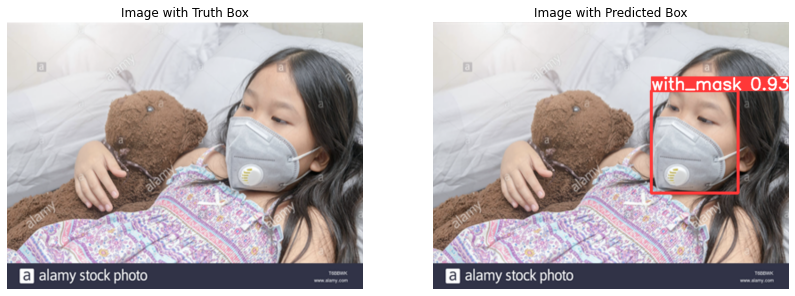

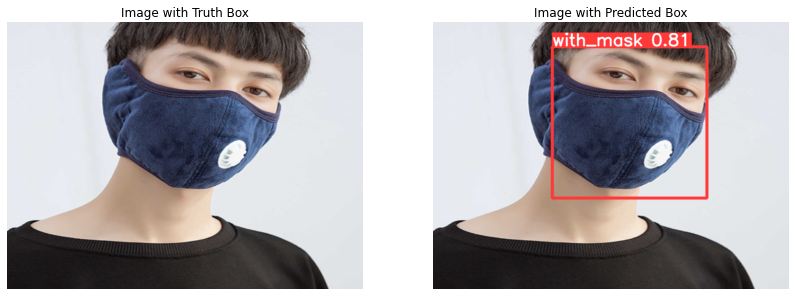

In [14]:
import os, random
show_image(random.choice(os.listdir("data/test/images/"))) 
show_image(random.choice(os.listdir("data/test/images/"))) 
plt.show()

In [ ]:
!python3 detect.py --source 0 --weight runs/train/yolov5s_results/weights/best.pt 